# Mercedes-Benz Greener Manufacturing - Reduce the time a Mercedes-Benz spends on the test bench

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

color = sns.color_palette()
%matplotlib inline

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [3]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


y is the target variable.

In [4]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [5]:
dtype_df[dtype_df['Column Type'] == 'object']

,Count,Column Type
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


In [6]:
dtype_df[dtype_df['Column Type'] == 'float64']

,Count,Column Type
1,y,float64


###### Check for null and unique values for test and train sets.

In [7]:
# Check for missing values training dataset
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [8]:
# Check for missing values training dataset
missing_df = test_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


###### There are no missing values in both train and test dataset

In [9]:
# Check the columns with integer values for the unique values
unique_values_dict = {}
for col in train_df.columns:
    if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(train_df[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145'

###### If for any column(s), the variance is equal to zero, then you need to remove those variable(s)

In [10]:
zero_var_cols = []
for col in train_df.columns:
    if (len(train_df[col].unique()) < 2):
        zero_var_cols.append(col)
print(zero_var_cols)

['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


In [11]:
# Drop the columns
train_df.drop(zero_var_cols, axis = 1, inplace=True)
test_df.drop(zero_var_cols, axis = 1, inplace=True)

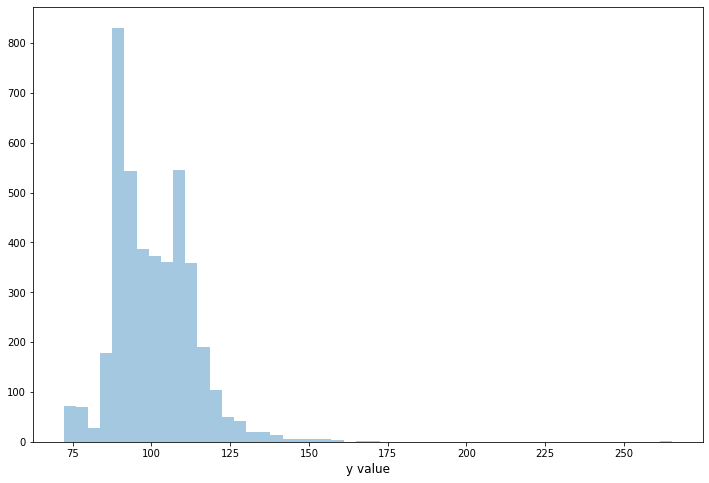

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.show()

In [13]:
# Check the unique values for categorical columns 
for x in ['X0','X1','X2','X3','X4','X5','X6','X8']:
    print(x,' - ',train_df[x].unique())

X0  -  ['k' 'az' 't' 'al' 'o' 'w' 'j' 'h' 's' 'n' 'ay' 'f' 'x' 'y' 'aj' 'ak' 'am'
 'z' 'q' 'at' 'ap' 'v' 'af' 'a' 'e' 'ai' 'd' 'aq' 'c' 'aa' 'ba' 'as' 'i'
 'r' 'b' 'ax' 'bc' 'u' 'ad' 'au' 'm' 'l' 'aw' 'ao' 'ac' 'g' 'ab']
X1  -  ['v' 't' 'w' 'b' 'r' 'l' 's' 'aa' 'c' 'a' 'e' 'h' 'z' 'j' 'o' 'u' 'p' 'n'
 'i' 'y' 'd' 'f' 'm' 'k' 'g' 'q' 'ab']
X2  -  ['at' 'av' 'n' 'e' 'as' 'aq' 'r' 'ai' 'ak' 'm' 'a' 'k' 'ae' 's' 'f' 'd'
 'ag' 'ay' 'ac' 'ap' 'g' 'i' 'aw' 'y' 'b' 'ao' 'al' 'h' 'x' 'au' 't' 'an'
 'z' 'ah' 'p' 'am' 'j' 'q' 'af' 'l' 'aa' 'c' 'o' 'ar']
X3  -  ['a' 'e' 'c' 'f' 'd' 'b' 'g']
X4  -  ['d' 'b' 'c' 'a']
X5  -  ['u' 'y' 'x' 'h' 'g' 'f' 'j' 'i' 'd' 'c' 'af' 'ag' 'ab' 'ac' 'ad' 'ae'
 'ah' 'l' 'k' 'n' 'm' 'p' 'q' 's' 'r' 'v' 'w' 'o' 'aa']
X6  -  ['j' 'l' 'd' 'h' 'i' 'a' 'g' 'c' 'k' 'e' 'f' 'b']
X8  -  ['o' 'x' 'e' 'n' 's' 'a' 'h' 'p' 'm' 'k' 'd' 'i' 'v' 'j' 'b' 'q' 'w' 'g'
 'y' 'l' 'f' 'u' 'r' 't' 'c']


In [14]:
#Plot the categorial values distribution

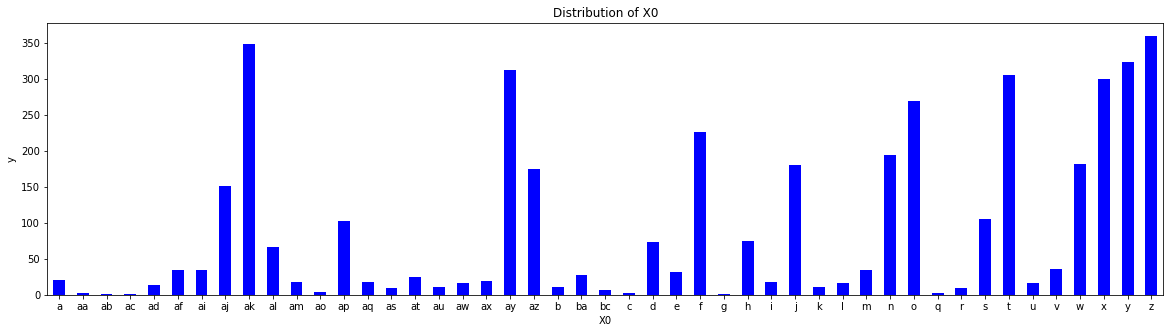

In [15]:
train_df.groupby('X0')['y'].count().\
    plot(kind = 'bar', color = 'blue',figsize = (20,5))
plt.xlabel('X0')
plt.ylabel('y')
plt.title('Distribution of X0')
plt.xticks(rotation=0)
plt.show()

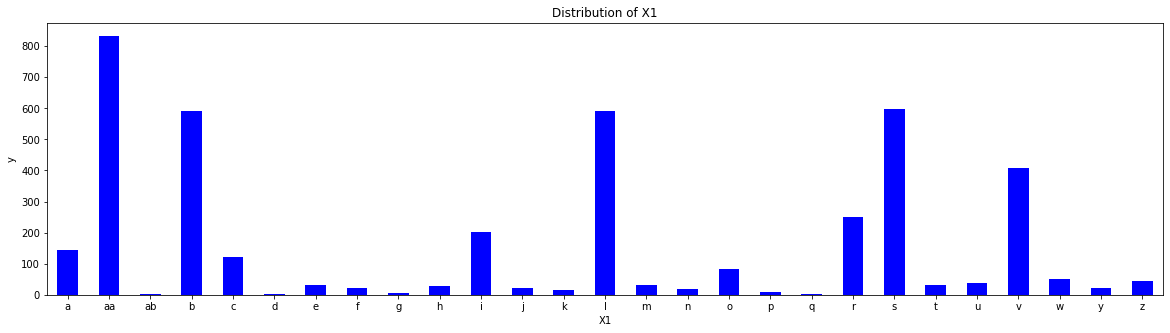

In [16]:
train_df.groupby('X1')['y'].count().\
    plot(kind = 'bar', color = 'blue',figsize = (20,5))
plt.xlabel('X1')
plt.ylabel('y')
plt.title('Distribution of X1')
plt.xticks(rotation=0)
plt.show()

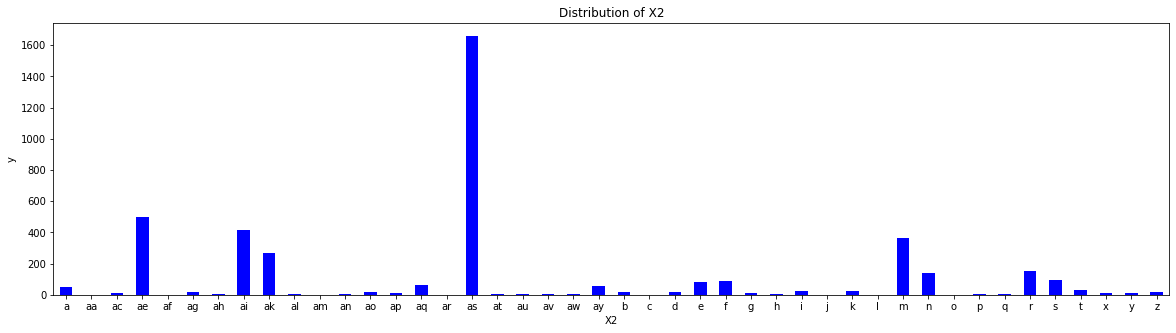

In [17]:
train_df.groupby('X2')['y'].count().\
    plot(kind = 'bar', color = 'blue',figsize = (20,5))
plt.xlabel('X2')
plt.ylabel('y')
plt.title('Distribution of X2')
plt.xticks(rotation=0)
plt.show()

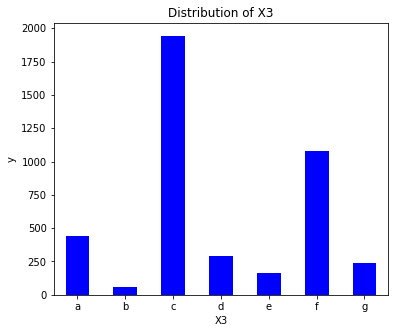

In [18]:
train_df.groupby('X3')['y'].count().\
    plot(kind = 'bar', color = 'blue',figsize = (6,5))
plt.xlabel('X3')
plt.ylabel('y')
plt.title('Distribution of X3')
plt.xticks(rotation=0)
plt.show()

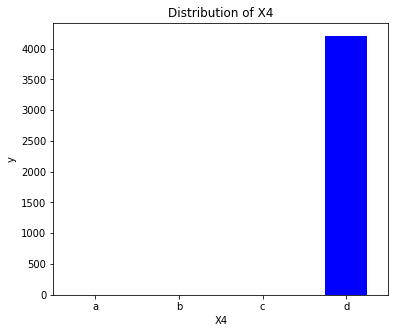

In [19]:
train_df.groupby('X4')['y'].count().\
    plot(kind = 'bar', color = 'blue',figsize = (6,5))
plt.xlabel('X4')
plt.ylabel('y')
plt.title('Distribution of X4')
plt.xticks(rotation=0)
plt.show()

In [20]:
train_df.groupby('X4')['y'].count()

X4
a       2
b       1
c       1
d    4205
Name: y, dtype: int64

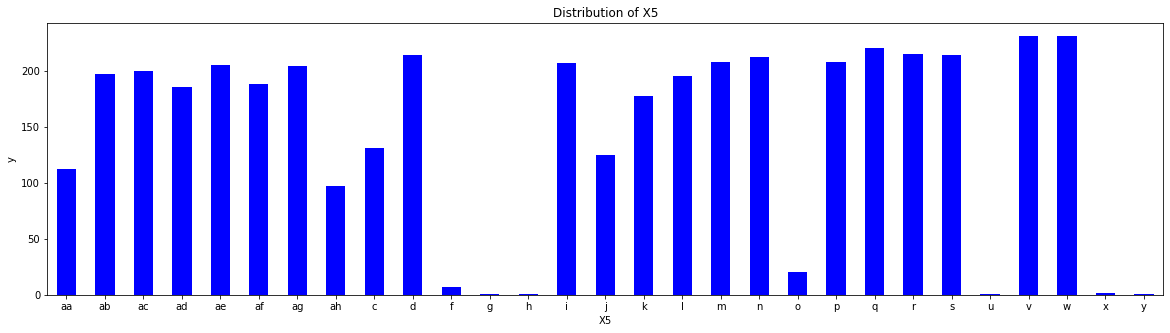

In [21]:
train_df.groupby('X5')['y'].count().\
    plot(kind = 'bar', color = 'blue',figsize = (20,5))
plt.xlabel('X5')
plt.ylabel('y')
plt.title('Distribution of X5')
plt.xticks(rotation=0)
plt.show()

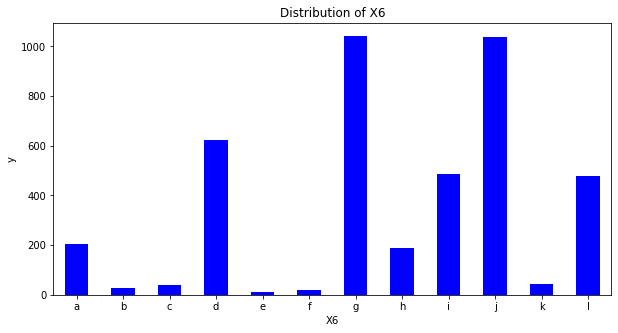

In [22]:
train_df.groupby('X6')['y'].count().\
    plot(kind = 'bar', color = 'blue',figsize = (10,5))
plt.xlabel('X6')
plt.ylabel('y')
plt.title('Distribution of X6')
plt.xticks(rotation=0)
plt.show()

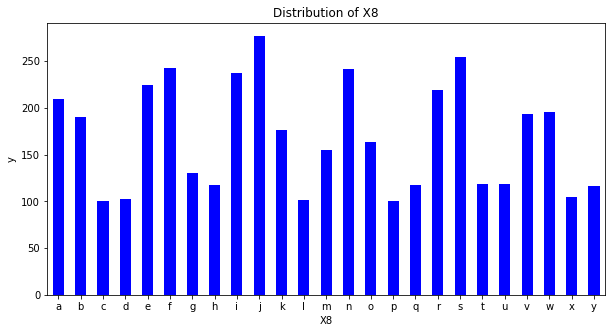

In [23]:
train_df.groupby('X8')['y'].count().\
    plot(kind = 'bar', color = 'blue',figsize = (10,5))
plt.xlabel('X8')
plt.ylabel('y')
plt.title('Distribution of X8')
plt.xticks(rotation=0)
plt.show()

###### Apply label encoder.

In [24]:
print(len(train_df), len(test_df))

4209 4209


In [25]:
# merge the two datasets before apply label encoding
test_df['y']=-1
df = pd.concat([train_df, test_df], axis=0)
len(df)

C:\Users\sushm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


8418

In [26]:
# Apply the encoder on the 8 categorial columns
from sklearn.preprocessing import LabelEncoder
df = pd.concat([train_df, test_df], axis=0)
for col in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        label_encoder = LabelEncoder()
        label_encoder.fit(list(df[col].values)) 
        df[col] = label_encoder.transform(list(df[col].values))

C:\Users\sushm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
# Separate the train and test datasets
train_df = df[df['y']!=-1]
test_df = df[df['y']==-1]

In [28]:
# Divide the features and labels from the training dataset
# Store the test IDs for sotirng the predicted y values later
# ID column can be removed from the datasets as it is not going to impact the prediction
y_train = train_df['y'].values
train_features = list(set(train_df.columns) - set(['ID', 'y']))
train_df = train_df[train_features]
id_test = test_df['ID'].values
test_df = test_df[train_features]

###### Perform dimensionality reduction.

In [29]:
# Perform PCA on the datatsets to move into 20 components feature sets
n_comp = 20
pca = PCA(n_components=n_comp, random_state=111)
pca_train = pca.fit_transform(train_df)
pca_test = pca.transform(test_df)

In [30]:
pca_train

array([[-2.07635904e-01,  2.44432248e-02,  1.48645082e+01, ...,
         9.02162164e-01, -8.19040502e-01,  6.24743556e-02],
       [-2.44087570e-01,  1.73167468e+00,  1.82110804e+01, ...,
         2.70318686e-01,  1.23630124e+00, -1.36445060e-01],
       [ 1.62731508e+01,  1.37845266e+01,  1.79269909e+01, ...,
        -1.11214480e+00, -5.73675646e-01,  6.65453912e-01],
       ...,
       [ 3.10773913e+01,  1.60215078e+01, -1.14345977e+01, ...,
        -9.68446669e-01, -2.12996827e-01,  3.55021363e-01],
       [ 2.56465558e+01,  2.81245083e+00, -1.22524179e+01, ...,
        -4.42758126e-01, -1.98176636e-01,  8.27438007e-01],
       [-1.88429811e+01, -1.09969233e+01, -1.01931362e+01, ...,
        -1.04679582e+00, -1.56212515e-02, -1.85852625e-02]])

In [31]:
pca_test

array([[ 16.18289407,  13.73001303,  13.920663  , ...,  -0.22413229,
          0.5836629 ,  -0.37841726],
       [-15.79832676,  -8.61091793,  -7.33675658, ...,  -0.39438444,
          0.26725152,   0.81676232],
       [ 12.38273372,  -3.22768676, -11.81372649, ...,   0.43180522,
         -0.88499815,  -0.52312183],
       ...,
       [-13.69358207,   2.20806502,  -8.83150969, ...,  -1.03634861,
         -0.83349517,   0.43247594],
       [ 25.43442203,  -7.03546588, -11.37025294, ...,  -0.4398109 ,
          0.30018781,  -0.25511342],
       [-15.89064222,  -8.12461623, -15.70919773, ...,  -1.02814861,
         -0.13342262,  -0.7779811 ]])

In [32]:
# Splilt the training dataset into train and test 
X_train, X_validation, y_train, y_validation = train_test_split(pca_train, y_train, test_size = 0.3, random_state = 11)

In [33]:
# Train the XGBoost Model
d_train = xgb.DMatrix(X_train, label = y_train)
d_validation = xgb.DMatrix(X_validation, label = y_validation)
d_test = xgb.DMatrix(pca_test)

In [34]:
params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_validation, 'valid')]

clf = xgb.train(params, d_train, 
                1000, watchlist, early_stopping_rounds=50, 
                feval=xgb_r2_score, maximize=True, verbose_eval=10)

[22:59:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:99.07420	valid-rmse:98.73159	train-r2:-57.93165	valid-r2:-65.27562
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.19376	valid-rmse:80.84573	train-r2:-38.57972	valid-r2:-43.43812
[20]	train-rmse:66.61863	valid-rmse:66.26359	train-r2:-25.64519	valid-r2:-28.85324
[30]	train-rmse:54.74879	valid-rmse:54.38670	train-r2:-16.99602	valid-r2:-19.11069
[40]	train-rmse:45.08702	valid-rmse:44.69395	train-r2:-11.20480	valid-r2:-12.58123
[50]	train-rmse:37.23350	valid-rmse:36.81680	train-r2:-7.32329	valid-r2:-8.21581
[60]	train-rmse:30.87389	valid-rmse:30.44744	train-r2:-4.72282	valid-r2:-5.30294
[70]	train-rmse:25.75202	valid-rmse:25.31521	train-r2:-2.98153	valid-r2:-3.35717
[80]	train-rmse:21.65297	

###### Predict your test_df values using XGBoost.

In [35]:
p_test = clf.predict(d_test)

res = pd.DataFrame()

res['ID'] = id_test
res['y'] = p_test

res.to_csv('xgb_mercedes.csv', index=False)

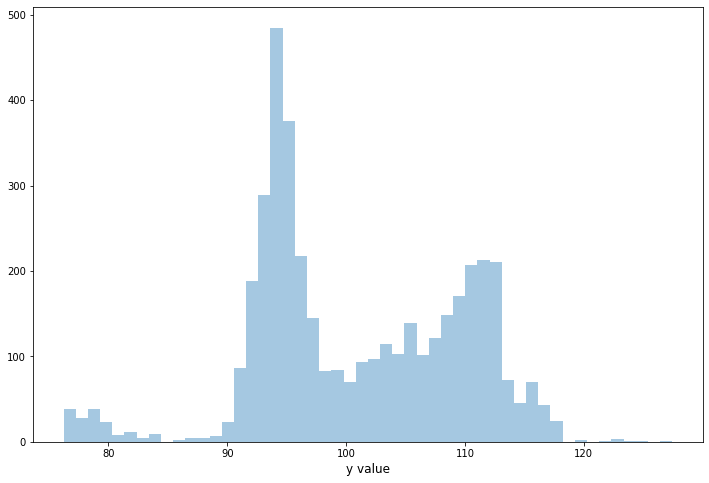

In [36]:
plt.figure(figsize=(12,8))
sns.distplot(res.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.show()